### Install libraries (for colab)

In [1]:
# !pip install pytorch_lightning
# !pip install transformers
# !pip install pytorch_lightning==1.8.5

### download the data

if you'd like you can put you kaggle token here to download the data from kaggle

In [2]:
# download the data using Kaggle API from https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
# !pip install kaggle
# !mkdir .kaggle
# import json
# token = {"username":"","key":""}
# with open('/content/.kaggle/kaggle.json', 'w') as file: #
#     json.dump(token, file)
# !chmod 600 /content/.kaggle/kaggle.json
# !kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis
# !unzip twitter-entity-sentiment-analysis.zip
# !mkdir data
# !mv *.csv data/

### Import the libraries

In [3]:
import pandas as pd
import numpy as np 
import re 
import os
import random
import matplotlib.pyplot as plt
import torch
from transformers import DistilBertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from transformers import DistilBertTokenizerFast
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# starting the tensorboard so we can see the logs while training
%load_ext tensorboard

In [4]:
def set_seed(random_state):
    """
    Set all seeds to make results reproducible.
    """
    random.seed(random_state)
    os.environ["PYTHONHASHSEED"] = str(random_state)
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed(random_state)

set_seed(42)

### Read the data

In [5]:
pd.read_csv("data/twitter_training.csv").head(1)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...


In [6]:
column_names=['Tweet_ID','Entity','Sentiment','Tweet_content'] # the csv files don't have column names, so I need to add them

train_df = pd.read_csv("data/twitter_training.csv",
                    sep=',',names=column_names)

validation_df = pd.read_csv("data/twitter_validation.csv",
                    sep=',',names=column_names)

print(f"Train samples : {train_df.shape[0]}", f"Validation samples : {validation_df.shape[0]}")

Train samples : 74682 Validation samples : 1000


In [7]:
# drop all the rows wit sentiment = 'irrelevant' because I don't use the entity in this project
train_df = train_df[train_df['Sentiment'] != 'Irrelevant']
validation_df = validation_df[validation_df['Sentiment'] != 'Irrelevant']
print(f"Train samples : {train_df.shape[0]}", f"Validation samples : {validation_df.shape[0]}")

Train samples : 61692 Validation samples : 828


### Preprocessing the tweets

In [8]:
def clean_text(text):
    '''
    Make text lowercase, and remove: links, html, new lines and multiple spaces.

    Parameters
    ----------
    text : str
        The text to be cleaned.

    Returns
    -------
    text : str
        The cleaned text.
    '''
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove links
    text = re.sub('<.*?>+', '', text) # remove html
    text = re.sub('\n', '', text) # remove new lines
    text = re.sub(' +', ' ', text) # remove multiple spaces
    return text

In [9]:
# checking nan values in train_df and validation_df datasets
print("* train_df nan values per column")
print(train_df.isna().sum())
print()
print("* validation_df nan values per column")
print(validation_df.isna().sum())

print()
# checking duplicated values
print(f"* duplicates in train_df: {train_df.duplicated().sum()}")
print(f"* duplicates in validation_df: {validation_df.duplicated().sum()}")

* train_df nan values per column
Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    571
dtype: int64

* validation_df nan values per column
Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64

* duplicates in train_df: 2294
* duplicates in validation_df: 0


In [10]:
# cleaning the train and test datasets
print(f"Before data cleaning: Train samples : {train_df.shape[0]}", f"Validation samples : {validation_df.shape[0]}")
train_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)

train_df['Tweet_content'] = train_df['Tweet_content'].apply(lambda x: clean_text(x))
validation_df['Tweet_content'] = validation_df['Tweet_content'].apply(lambda x: clean_text(x))

print(f"After data cleaning: Train samples : {train_df.shape[0]}", f"Validation samples : {validation_df.shape[0]}")

Before data cleaning: Train samples : 61692 Validation samples : 828
After data cleaning: Train samples : 59119 Validation samples : 828


### Visualize the data

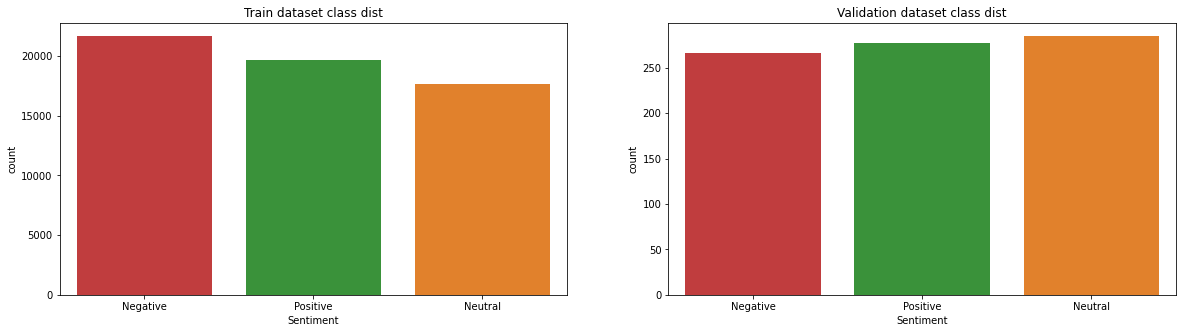

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

palette = {'Negative':'#d62728', 'Positive':'#2ca02c', 'Neutral':'#ff7f0e'}# Use the same color palette for both countplots
order = ['Negative', 'Positive', 'Neutral']

sns.countplot(x='Sentiment', data=train_df, ax=ax[0], order=order, palette=palette)
sns.countplot(x='Sentiment', data=validation_df, ax=ax[1], order=order, palette=palette)

ax[0].set_title("Train dataset class dist")
ax[1].set_title("Validation dataset class dist")

plt.show()

In [12]:
def viz_len_dist(train_df, validation_df):
    # plotting the distribution of the text length for train and validation datasets
    _, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(train_df['text_len'],ax=axes[0],color='blue')
    sns.histplot(validation_df['text_len'],ax=axes[1],color='red')
    axes[0].set_title('Train text length distribution')
    axes[1].set_title('Validation text length distribution')
    plt.show()

In [13]:
# getting the text len so later I can use it for calculating the distribution of the text length
train_df['text_len']=train_df['Tweet_content'].apply(lambda x: len(x.split()))
validation_df['text_len']=validation_df['Tweet_content'].apply(lambda x: len(x.split()))

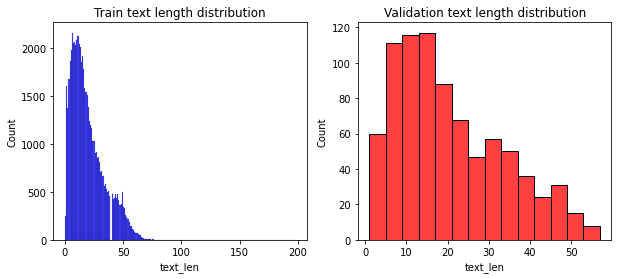

In [14]:
viz_len_dist(train_df, validation_df)

In [15]:
print(f"Longest text in train_df has {train_df['text_len'].max()} words")

# find the percentile 99 of the text length for train_df
percentile_99 = int(np.percentile(train_df['text_len'], 99))
print(f"99th percentile of the text length for train_df: {percentile_99}")

# find the outlier max len using the IQR method
q1 = train_df['text_len'].quantile(0.25)
q3 = train_df['text_len'].quantile(0.75)
iqr = q3-q1 #Interquartile range
fence_high = int(q3+1.5*iqr)
print(f"Outlier max len using IQR: {fence_high}")

Longest text in train_df has 198 words
99th percentile of the text length for train_df: 59
Outlier max len using IQR: 55


In [16]:
seq_max_len = int(min(percentile_99, fence_high))
seq_max_len

55

In [17]:
# truncate the text length to 99 percentile for train_df and validation_df
# this helps us with getting rid of outliers and I don't have to pad the text to the max length and include a lot of zeros
def truncate_to_len(text, max_len):
    '''
    Truncates the text to the given max_len.
    '''
    if len(text.split()) > max_len:
        text = " ".join(text.split()[:max_len])
    return text

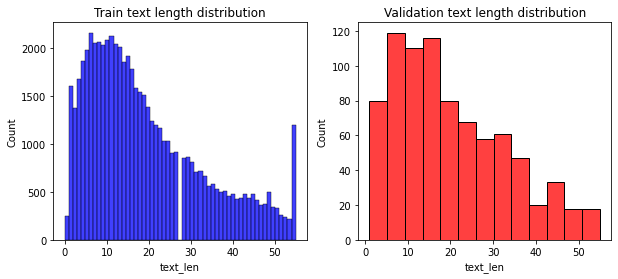

In [18]:
train_df['Tweet_content'] = train_df['Tweet_content'].apply(lambda x: truncate_to_len(x, int(seq_max_len)))
validation_df['Tweet_content'] = validation_df['Tweet_content'].apply(lambda x: truncate_to_len(x, int(seq_max_len)))

train_df['text_len']=train_df['Tweet_content'].apply(lambda x: len(x.split()))
validation_df['text_len']=validation_df['Tweet_content'].apply(lambda x: len(x.split()))

viz_len_dist(train_df, validation_df)

In [19]:
# max len in train_df and validation_df
print(f"Max len in train_df: {train_df['text_len'].max()}")

Max len in train_df: 55


### Train Val Test Split

To create a separate test set while maintaining a reasonable size for the validation set, I allocate 15% of the training set to the validation set. By doing so, I ensure that the test set consists of data that the model has never encountered before, as it originates from the validation set. This approach helps prevent overfitting to the validation set and allows for a more reliable evaluation of the model's generalization performance.

In [20]:
train_text, val_train_text, y_train, y_val_train = train_test_split(
    train_df["Tweet_content"],
    train_df["Sentiment"],
    test_size=0.15,
    random_state=42,
    stratify=train_df["Sentiment"], # making sure the class dist is the same in both splits
)

val_text, test_text, y_val, y_test = train_test_split(
    validation_df["Tweet_content"],
    validation_df["Sentiment"],
    test_size=0.5,
    random_state=42,
    stratify=validation_df["Sentiment"], # making sure the class dist is the same in both splits
)

val_text = pd.concat([val_train_text, val_text], axis=0)
y_val = pd.concat([y_val_train, y_val], axis=0)

# convert the text to lists
train_text = train_text.tolist()
val_text = val_text.tolist()
test_text = test_text.tolist()

# encode the target variable using LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# calculating the class weights because of the class imbalance
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
class_weights = torch.tensor(class_weights, device=device, dtype=torch.float)

print(f"Train samples: {len(y_train)} Validation samples: {len(y_val)}", f"Test samples: {len(y_test)}")
print(f"Val/Train ratio: {len(y_val)/len(y_train):.2f}")
print(f"Class weights: {class_weights}")

Train samples: 50251 Validation samples: 9282 Test samples: 414
Val/Train ratio: 0.18
Class weights: tensor([0.9082, 1.1128, 0.9997], device='cuda:0')


### Model Building

In [21]:
class TweetDataset(torch.utils.data.Dataset):
    """
    Dataset which stores the tweets and returns them as processed features
    that can be directly fed to the model
    """

    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding= "max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True
        )
        return dict(
            text=text,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            targets=torch.tensor(target, dtype=torch.long)
        )

In [22]:
class SentimentClassifier(pl.LightningModule):
    def __init__(
        self,
        n_classes: int,
        class_weights=None,
        n_training_steps=None,
        n_warmup_steps=None,
    ):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.loss = torch.nn.functional.cross_entropy
        self.class_weights = class_weights

        # for retrieving the metrics in on_epoch_end
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

        # for plotting the results after training is done
        self.train_losses, self.train_accs, self.train_f1s = [], [], []
        self.val_losses, self.val_accs, self.val_f1s = [], [], []

        # I have specified the lr manually so the tuner can change it later
        self.lr= 2e-5

    def forward(self, inp):
        output_1 = self.bert(
            input_ids=inp["input_ids"], attention_mask=inp["attention_mask"]
        )
        hidden_state = output_1[
            0
        ]  # using the last hidden state as the representation of the text
        x = hidden_state[:, 0]
        x = self.pre_classifier(x)
        x = torch.nn.ReLU()(x)
        x = self.dropout(x)
        output = self.classifier(x)
        output = torch.nn.functional.softmax(output, dim=1)
        return output

    def training_step(self, batch, batch_idx):
        targets = batch["targets"]
        outputs = self(batch)
        loss = self.loss(
            outputs, targets, self.class_weights
        )  # using the class weights to handle class imbalance
        accuracy = accuracy_score(targets.cpu(), outputs.cpu().argmax(dim=1))
        f1 = f1_score(targets.cpu(), outputs.cpu().argmax(dim=1), average="weighted")

        logs = {
            "loss": loss,
            "accuracy": torch.tensor(accuracy),
            "f1": torch.tensor(f1),
        }

        self.training_step_outputs.append(logs)

        return loss

    def validation_step(self, batch, batch_idx):
        targets = batch["targets"]
        outputs = self(batch)
        loss = self.loss(
            outputs, targets, self.class_weights
        )  # using the class weights to handle class imbalance
        accuracy = accuracy_score(targets.cpu(), outputs.cpu().argmax(dim=1))
        f1 = f1_score(targets.cpu(), outputs.cpu().argmax(dim=1), average="weighted")

        logs = {
            "loss": loss,
            "accuracy": torch.tensor(accuracy),
            "f1": torch.tensor(f1),
        }

        self.validation_step_outputs.append(logs)

        return loss

    def test_step(self, batch, batch_idx):
        targets = batch["targets"]
        outputs = self(batch)
        loss = self.loss(outputs, targets, self.class_weights)
        accuracy = accuracy_score(targets.cpu(), outputs.cpu().argmax(dim=1))
        f1 = f1_score(targets.cpu(), outputs.cpu().argmax(dim=1), average="weighted")

        logs = {
            "loss": loss,
            "accuracy": torch.tensor(accuracy),
            "f1": torch.tensor(f1),
        }

        self.test_step_outputs.append(logs)

        return loss
    
    def on_train_epoch_end(self):
        avg_loss = torch.stack([x["loss"] for x in self.training_step_outputs]).mean()
        avg_acc = torch.stack(
            [x["accuracy"] for x in self.training_step_outputs]
        ).mean()
        avg_f1 = torch.stack([x["f1"] for x in self.training_step_outputs]).mean()

        self.log("train_loss", avg_loss)
        self.log("train_accuracy", avg_acc)
        self.log("train_f1_score", avg_f1, prog_bar=True)
        self.log("lr_rate", self.trainer.optimizers[0].param_groups[0]["lr"], prog_bar=True)

        self.train_losses.append(avg_loss.detach().cpu())
        self.train_accs.append(avg_acc.detach().cpu())
        self.train_f1s.append(avg_f1.detach().cpu())

        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([x["loss"] for x in self.validation_step_outputs]).mean()
        avg_acc = torch.stack(
            [x["accuracy"] for x in self.validation_step_outputs]
        ).mean()
        avg_f1 = torch.stack([x["f1"] for x in self.validation_step_outputs]).mean()

        self.log("val_loss", avg_loss)
        self.log("val_accuracy", avg_acc)
        self.log("val_f1_score", avg_f1, prog_bar=True)

        self.val_losses.append(avg_loss.detach().cpu())
        self.val_accs.append(avg_acc.detach().cpu())
        self.val_f1s.append(avg_f1.detach().cpu())

        self.validation_step_outputs.clear()

    def on_test_epoch_end(self):
        avg_loss = torch.stack([x["loss"] for x in self.test_step_outputs]).mean()
        avg_acc = torch.stack([x["accuracy"] for x in self.test_step_outputs]).mean()
        avg_f1 = torch.stack([x["f1"] for x in self.test_step_outputs]).mean()

        self.log("test_loss", avg_loss)
        self.log("test_accuracy", avg_acc)
        self.log("test_f1_score", avg_f1)

        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.lr)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps,
        )
        return dict(
            optimizer=optimizer, lr_scheduler=dict(scheduler=scheduler, interval="step")
        )
    
    def plot_history(self):
        # plot the training and validation loss, accuracy and f1 score
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].plot(self.train_losses, label="train_loss")
        axes[0].plot(self.val_losses, label="val_loss")
        axes[0].set_title("Loss")
        axes[0].legend()

        axes[1].plot(self.train_accs, label="train_accuracy")
        axes[1].plot(self.val_accs, label="val_accuracy")
        axes[1].set_title("Accuracy")
        axes[1].legend()

        axes[2].plot(self.train_f1s, label="train_f1_score")
        axes[2].plot(self.val_f1s, label="val_f1_score")
        axes[2].set_title("F1 Score")
        axes[2].legend()

        plt.show()


In [23]:
def get_dataloader(texts:list, labels:list, max_len:int, tokenizer, batch_size=64, shuffle=True):
    """
    Returns a dataloader for the given texts and labels
    
    Parameters
    ----------
    texts : list
        List of texts
    labels : list
        List of labels
    max_len : int
        Maximum length of the text
    tokenizer : DistilBertTokenizerFast
        Tokenizer to use
    batch_size : int, optional
        Batch size, by default 64
    shuffle : bool, optional
        Whether to shuffle the data, by default True

    Returns
    -------
    DataLoader
        Dataloader for the given texts and labels
    """

    dataset = TweetDataset(
        texts=texts,
        targets=labels,
        tokenizer=tokenizer,
        max_len=max_len
    )
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle
    )
    return dataloader

In [24]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_dataloader = get_dataloader(train_text, y_train, seq_max_len, tokenizer, shuffle=True)
val_dataloader = get_dataloader(val_text, y_val, seq_max_len, tokenizer, shuffle=False)
test_dataloader = get_dataloader(test_text, y_test, seq_max_len, tokenizer, shuffle=False)

In [25]:
tb_logger = TensorBoardLogger("logs/")

chkpt_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=False,
    monitor="val_f1_score",
    mode="max",
    save_weights_only=True
)

In [26]:
# training the model
epochs = 10
n_classes = np.unique(y_train).shape[0]
n_training_steps = len(train_dataloader) * epochs # total number of training steps
n_warmup_steps = n_training_steps // 10 # 10% of train data for warm-up

model = SentimentClassifier(
    n_classes=n_classes,
    class_weights=class_weights,
    n_training_steps=n_training_steps,
    n_warmup_steps=n_warmup_steps,
)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=epochs,
    callbacks=[
        chkpt_callback,
    ],
    logger=tb_logger,
    enable_progress_bar=True,
    enable_model_summary=False,
    # overfit_batches=1,
    auto_lr_find = True
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [27]:
trainer.tune(model, train_dataloader, val_dataloader, lr_find_kwargs={"min_lr":1e-7, "max_lr": 2e-5}) # find the optimal learning rate
trainer.fit(model, train_dataloader, val_dataloader)

/home/jlw742/pytorch/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/jlw742/projects/in_progress/twitter_sentiment_analysis_Bert/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jlw742/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jlw742/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the v

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 1.798909833250475e-05
Restoring states from the checkpoint path at /home/jlw742/projects/in_progress/twitter_sentiment_analysis_Bert/.lr_find_71aa3f6e-8844-4a82-97b6-64528a2c200d.ckpt
Restored all states from the checkpoint file at /home/jlw742/projects/in_progress/twitter_sentiment_analysis_Bert/.lr_find_71aa3f6e-8844-4a82-97b6-64528a2c200d.ckpt
/home/jlw742/pytorch/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/jlw742/projects/in_progress/twitter_sentiment_analysis_Bert/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

/home/jlw742/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jlw742/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


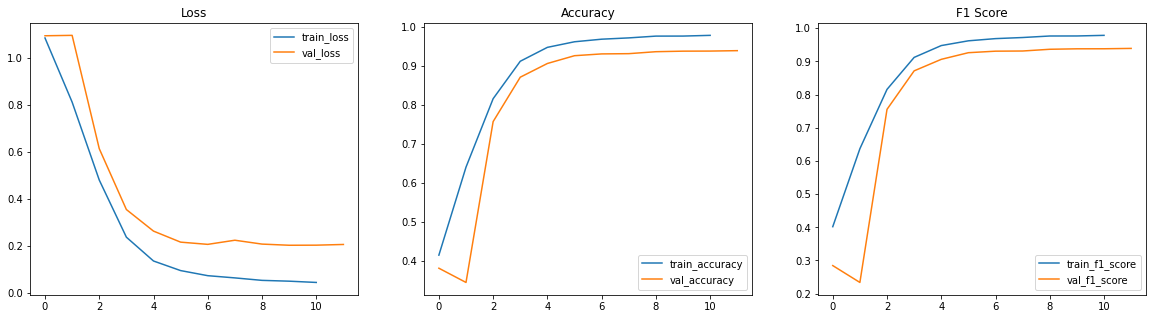

In [29]:
# I plot the training history here, in case tensorboard didn't work on colab for you
model.plot_history()

model is suffering from a bit of overfitting, it would probably perform better If I add weight decay and increase the dropout rate. But for the sake of this test project, I will leave it as it is.

In [40]:
trainer.test(model, test_dataloader, ckpt_path=chkpt_callback.best_model_path)

Restoring states from the checkpoint path at /home/jlw742/projects/in_progress/twitter_sentiment_analysis_Bert/checkpoints/best-checkpoint.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/jlw742/projects/in_progress/twitter_sentiment_analysis_Bert/checkpoints/best-checkpoint.ckpt
/home/jlw742/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9776785714285714     │
│       test_f1_score       │    0.9777957833015769     │
│         test_loss         │    0.09595669060945511    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.09595669060945511,
  'test_accuracy': 0.9776785714285714,
  'test_f1_score': 0.9777957833015769}]

In [35]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plots the confusion matrix for the given true and predicted labels

    Parameters
    ----------
    y_true : list
        List of true labels
    y_pred : list
        List of predicted labels
    labels : list
        List of labels
    """

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    _, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")
    plt.show()

Restoring states from the checkpoint path at /home/jlw742/projects/in_progress/twitter_sentiment_analysis_Bert/checkpoints/best-checkpoint.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/jlw742/projects/in_progress/twitter_sentiment_analysis_Bert/checkpoints/best-checkpoint.ckpt
/home/jlw742/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 786it [00:00, ?it/s]

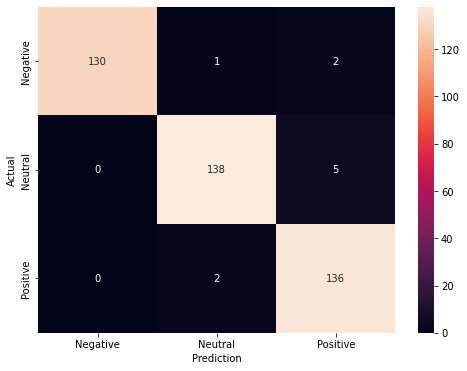

              precision    recall  f1-score   support

    Negative       1.00      0.98      0.99       133
     Neutral       0.98      0.97      0.97       143
    Positive       0.95      0.99      0.97       138

    accuracy                           0.98       414
   macro avg       0.98      0.98      0.98       414
weighted avg       0.98      0.98      0.98       414



In [41]:
y_pred = trainer.predict(model, test_dataloader, ckpt_path=chkpt_callback.best_model_path)
y_pred= [np.argmax(y, axis=1) for y in y_pred]
# flatten the list
y_pred = [item for sublist in y_pred for item in sublist]

# retiriving the class names
y_pred_names= le.inverse_transform(y_pred)
y_test_names= le.inverse_transform(y_test)

plot_confusion_matrix(y_test_names, y_pred_names, labels=le.classes_)

# print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_names, y_pred_names))

In [37]:
%tensorboard --logdir=logs/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Inference

if you would like to only test the model you can start running the code from here.

In [42]:
# load the model from the checkpoint
model = SentimentClassifier.load_from_checkpoint(
    "checkpoints/best-checkpoint.ckpt",
    n_classes=n_classes,
    class_weights=class_weights,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
def predict_sentence(text):
    """
    This function predicts the sentiment of a sentence. 
    The text is cleaned and tokenized before prediction.
    
    Parameters
    ----------
    text : str
        The text to be predicted
    
    Returns
    -------
    str
        The predicted sentiment which can be either 'positive', 'negative' or 'neutral'
    """
    # clean the text
    text = clean_text(text)

    # tokenize the text
    text = tokenizer.encode_plus(
        text,
        max_length=seq_max_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors="pt"
    )
    
    # predict the sentiment
    with torch.no_grad():
        output = model(dict(input_ids=text["input_ids"].to(model.device),
                            attention_mask=text["attention_mask"].to(model.device))
        )
        _, prediction = torch.max(output, dim=1)

    # inverse transform the prediction
    prediction = le.inverse_transform(prediction.cpu().numpy())[0]

    return prediction

In [44]:
# test the model with some sample sentences
assert predict_sentence("I love this movie. It is great!") == "Positive"
assert predict_sentence("I hate this movie. It is bad!") == "Negative"
assert predict_sentence("wanna see a movie @ the theatre?") == "Neutral"